In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_device('cpu')

import numpy as np
from tqdm import tqdm

from transformers_simple.fcn import FCN
from transformers_simple.train import Trainer
from transformers_simple.dataset import CharDataset
from transformers_simple.char_util import generate_sample

In [2]:
N = int(1e4)
block_size  = 64
embed_size  = 128
hidden_size = 256

vocab_size  = 3
input_size = block_size*embed_size

batch_size = 8
log_interval = 100 
epochs = 1
train_iters = 3000
learning_rate = 1e-4
device = torch.device('cpu')

In [3]:
# # simple test case
# data = "".join(["aabcacb"]*N)

# dataset = CharDataset(data=data, block_size=block_size)

# dataset_train, dataset_test = dataset.train_test_split(train_fraction=0.5)

In [4]:
dataset = CharDataset(filename="../datasets/shakespeare.txt", block_size=block_size)

dataset_train, dataset_test = dataset.train_test_split(train_fraction=0.9)

In [5]:
vocab_size = dataset_train.vocab_size
output_size = vocab_size

In [6]:
loss = torch.nn.CrossEntropyLoss()

def loss_fn(o,y):
    return loss(o,y[:,-1])

In [7]:
embedder = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)

fc1 = FCN(input_size=block_size*embed_size,
         output_size=hidden_size,
         hidden_size=hidden_size,
         num_layers=1,
         activation=torch.nn.LeakyReLU(0.05),
         output_activation=torch.nn.LeakyReLU(0.05))

fc2 = FCN(input_size=hidden_size,
         output_size=vocab_size,
          hidden_size=hidden_size,
         num_layers=1,
         activation=torch.nn.LeakyReLU(0.05),
         output_activation=torch.nn.Identity())

In [8]:
model1 = torch.nn.Sequential(
    embedder, # output is (nb,block_size, embed_size)
    torch.nn.Flatten(start_dim=1), #output now (nb, block_size*embed_size)
    fc1, #output is now (nb, hidden_size)
    torch.nn.Linear(hidden_size, vocab_size, bias=True)
)

In [9]:
trainer = Trainer(model=model1, 
                  dataset=dataset_train, 
                  loss_fn=loss_fn, 
                  batch_size=batch_size, 
                  learning_rate=learning_rate,
                  epochs=epochs, 
                  log_interval=log_interval, 
                  device=device,
                  max_iters=train_iters,
                  val_dataset=dataset_test,
                  val_interval=400,
                  max_val_iters=100,
                  warmup_iters=100,
                  lr_decay_iters=1000,
                  min_lr=1e-4)

In [10]:
trainer.run()

Train Epoch: 0 [0/1003790 (0%)]	Loss: 3.650569


100it [00:00, 710.10it/s]


Train Epoch: 0 [800/1003790 (0%)]	Loss: 3.221771
Train Epoch: 0 [1600/1003790 (0%)]	Loss: 3.363846
Train Epoch: 0 [2400/1003790 (0%)]	Loss: 2.546418
Train Epoch: 0 [3200/1003790 (0%)]	Loss: 2.434731


100it [00:00, 683.27it/s]


Train Epoch: 0 [4000/1003790 (0%)]	Loss: 2.669717
Train Epoch: 0 [4800/1003790 (0%)]	Loss: 2.811768
Train Epoch: 0 [5600/1003790 (1%)]	Loss: 3.159667
Train Epoch: 0 [6400/1003790 (1%)]	Loss: 2.736401


100it [00:00, 720.14it/s]


Train Epoch: 0 [7200/1003790 (1%)]	Loss: 2.215853
Train Epoch: 0 [8000/1003790 (1%)]	Loss: 2.749738
Train Epoch: 0 [8800/1003790 (1%)]	Loss: 3.101075
Train Epoch: 0 [9600/1003790 (1%)]	Loss: 2.775986


100it [00:00, 731.38it/s]


Train Epoch: 0 [10400/1003790 (1%)]	Loss: 2.338273
Train Epoch: 0 [11200/1003790 (1%)]	Loss: 2.645507
Train Epoch: 0 [12000/1003790 (1%)]	Loss: 2.611001
Train Epoch: 0 [12800/1003790 (1%)]	Loss: 2.464541


100it [00:00, 642.04it/s]


Train Epoch: 0 [13600/1003790 (1%)]	Loss: 2.779559
Train Epoch: 0 [14400/1003790 (1%)]	Loss: 2.590540
Train Epoch: 0 [15200/1003790 (2%)]	Loss: 2.951919
Train Epoch: 0 [16000/1003790 (2%)]	Loss: 2.402581


100it [00:00, 753.53it/s]


Train Epoch: 0 [16800/1003790 (2%)]	Loss: 2.878977
Train Epoch: 0 [17600/1003790 (2%)]	Loss: 2.836437
Train Epoch: 0 [18400/1003790 (2%)]	Loss: 2.561676
Train Epoch: 0 [19200/1003790 (2%)]	Loss: 3.425555


100it [00:00, 726.65it/s]


Train Epoch: 0 [20000/1003790 (2%)]	Loss: 2.184487
Train Epoch: 0 [20800/1003790 (2%)]	Loss: 2.452635
Train Epoch: 0 [21600/1003790 (2%)]	Loss: 2.212116
Train Epoch: 0 [22400/1003790 (2%)]	Loss: 3.165245


100it [00:00, 691.87it/s]


Train Epoch: 0 [23200/1003790 (2%)]	Loss: 3.028664
Train Epoch: 0 [24000/1003790 (2%)]	Loss: 2.655560


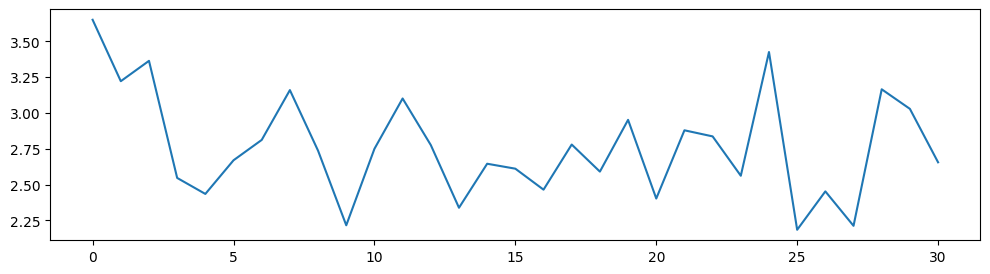

In [11]:
loss_history = trainer.loss_history

plt.figure(figsize=(12,3))
plt.plot(loss_history)
plt.show()

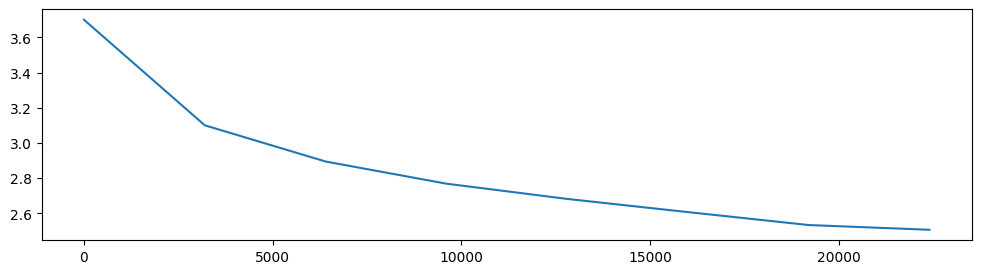

In [12]:
plt.figure(figsize=(12,3))
plt.plot(trainer.val_loss_iters, trainer.val_loss_history)
plt.show()

In [13]:
#convert to new dataset
xs = []
ys = []

X = np.zeros((len(dataset),hidden_size))
Y = torch.zeros((len(dataset),block_size), dtype=torch.long)

for i in tqdm(range(len(dataset))):
    x,y = dataset[i]

    xb = x.view(1,-1)

    z = embedder(xb)
    z = z.view(1,-1)
    xnew = fc1(z)[0]

    X[i] = xnew.data.numpy()
    Y[i] = y

100%|███████████████████████████████| 1115330/1115330 [07:10<00:00, 2591.06it/s]


In [14]:
Ns = int(0.5*X.shape[0])

data_train = TensorDataset(torch.Tensor(X[:Ns]), Y[:Ns])
data_test = TensorDataset(torch.Tensor(X[Ns:]), Y[Ns:])

In [15]:
model2 = fc2

In [16]:
trainer = Trainer(model=model2, 
                  dataset=data_train, 
                  loss_fn=loss_fn, 
                  batch_size=batch_size, 
                  learning_rate=learning_rate,
                  epochs=epochs, 
                  log_interval=log_interval, 
                  device=device,
                  max_iters=train_iters,
                  val_dataset=data_test,
                  val_interval=400,
                  max_val_iters=100,
                  warmup_iters=100,
                  lr_decay_iters=1000,
                  min_lr=1e-4)

In [17]:
trainer.run()

Train Epoch: 0 [0/557665 (0%)]	Loss: 3.685372


100it [00:00, 1175.88it/s]


Train Epoch: 0 [800/557665 (0%)]	Loss: 3.265803
Train Epoch: 0 [1600/557665 (0%)]	Loss: 2.839431
Train Epoch: 0 [2400/557665 (0%)]	Loss: 2.111705
Train Epoch: 0 [3200/557665 (1%)]	Loss: 1.564618


100it [00:00, 1513.97it/s]


Train Epoch: 0 [4000/557665 (1%)]	Loss: 3.033971
Train Epoch: 0 [4800/557665 (1%)]	Loss: 1.945762
Train Epoch: 0 [5600/557665 (1%)]	Loss: 2.061915
Train Epoch: 0 [6400/557665 (1%)]	Loss: 3.069638


100it [00:00, 1503.70it/s]


Train Epoch: 0 [7200/557665 (1%)]	Loss: 2.068596
Train Epoch: 0 [8000/557665 (1%)]	Loss: 2.551079
Train Epoch: 0 [8800/557665 (2%)]	Loss: 3.037666
Train Epoch: 0 [9600/557665 (2%)]	Loss: 3.035621


100it [00:00, 1491.44it/s]


Train Epoch: 0 [10400/557665 (2%)]	Loss: 1.884997
Train Epoch: 0 [11200/557665 (2%)]	Loss: 2.303853
Train Epoch: 0 [12000/557665 (2%)]	Loss: 2.122637
Train Epoch: 0 [12800/557665 (2%)]	Loss: 2.142152


100it [00:00, 1501.12it/s]


Train Epoch: 0 [13600/557665 (2%)]	Loss: 2.585068
Train Epoch: 0 [14400/557665 (3%)]	Loss: 2.478478
Train Epoch: 0 [15200/557665 (3%)]	Loss: 1.931220
Train Epoch: 0 [16000/557665 (3%)]	Loss: 2.187470


100it [00:00, 1512.03it/s]


Train Epoch: 0 [16800/557665 (3%)]	Loss: 2.789349
Train Epoch: 0 [17600/557665 (3%)]	Loss: 2.319602
Train Epoch: 0 [18400/557665 (3%)]	Loss: 2.954088
Train Epoch: 0 [19200/557665 (3%)]	Loss: 2.731347


100it [00:00, 1486.98it/s]


Train Epoch: 0 [20000/557665 (4%)]	Loss: 2.387640
Train Epoch: 0 [20800/557665 (4%)]	Loss: 2.074826
Train Epoch: 0 [21600/557665 (4%)]	Loss: 2.885520
Train Epoch: 0 [22400/557665 (4%)]	Loss: 2.639635


100it [00:00, 1523.06it/s]


Train Epoch: 0 [23200/557665 (4%)]	Loss: 2.805612
Train Epoch: 0 [24000/557665 (4%)]	Loss: 2.185497


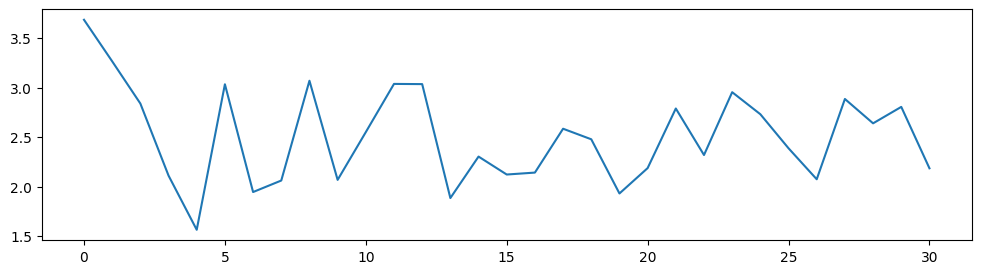

In [18]:
loss_history = trainer.loss_history

plt.figure(figsize=(12,3))
plt.plot(loss_history)
plt.show()

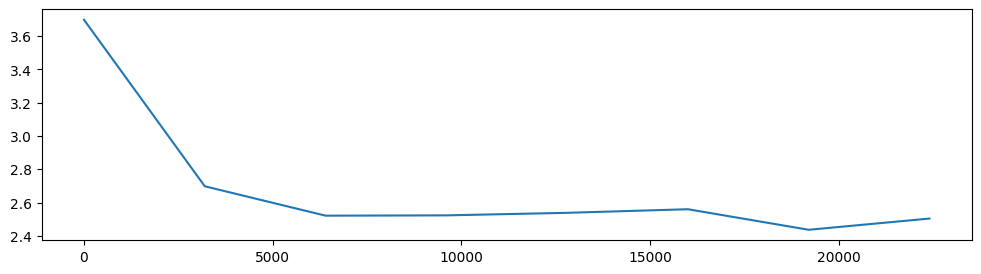

In [19]:
plt.figure(figsize=(12,3))
plt.plot(trainer.val_loss_iters, trainer.val_loss_history)
plt.show()